## MSDI Album art Image Analysis

In [1]:
import pandas as pd
import numpy as np
import tables
import h5py
import pickle

import math
import random

import os, sys, glob
from pathlib import Path

import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D

import tensorflow as tf

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 3276800

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://drive.google.com/u/0/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    




In [3]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6/view?usp=sharing
file_id = r'1wduOo4DLWGEAF44odjv6BQlsxYsO_0c6'
# DESTINATION FILE ON YOUR DISK
destination = 'shortlisted_tracks_df.pkl' #pickle4
download_file_from_google_drive(file_id, destination)

In [4]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/16VKAXPeAbqbOSrfZp2SSBajh3KezftuM/view?usp=sharing
file_id = r'16VKAXPeAbqbOSrfZp2SSBajh3KezftuM'
# DESTINATION FILE ON YOUR DISK
destination = 'aart_data.zip'
download_file_from_google_drive(file_id, destination)

In [5]:
!rm -rf aart_data
!unzip -q aart_data.zip

In [6]:
with open('shortlisted_tracks_df' +'.pkl', 'rb') as handle:
    shortlisted_tracks_df = pickle.load(handle)

In [7]:
shortlisted_tracks_df

,Genre
TrackId,
TREQVVI128F427C38E,Country
TRYCYSD128F148CF20,Country
TRLCZET12903D03F70,Country
TRJORPT128F42BAA8D,Country
TROBJYA128F42A2984,Country
...,...
TRQFZEO128E07930BC,Rock
TRNSWUN128F4247F87,Rock
TRLENOU128F4281E94,Rock


In [ ]:
track_id = 'TRAAHSY128F147BB5C'
parent_dir = 'aart_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4]
filepath = parent_dir + '/' + track_id + '.jpg'

import tensorflow as tf

raw_img = tf.io.read_file(filepath)
image_tmp = tf.image.decode_jpeg(raw_img)
#image = tf.image.resize(image_tmp, [128, 128], method='bicubic', antialias=True)
image = tf.image.resize(image_tmp, [128, 128])

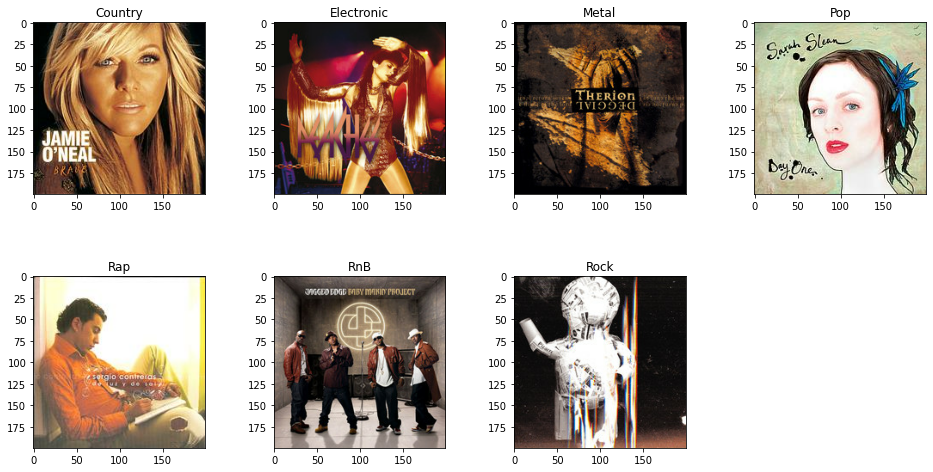

In [16]:
import tensorflow as tf

sample_indices = [0, 701, 1400, 2100, 2800, 3500, 4201]
fig = plt.figure(figsize=(16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, sample_index in enumerate(sample_indices):
  track_id = shortlisted_tracks_df.index.values[sample_index]
  genre = shortlisted_tracks_df.iloc[sample_index][0]

  filepath = 'aart_data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4] + '/' + track_id + '.jpg'

  #print ('mfcc plot for track_id=', track_id, " genre=", genre, " is: ")
  fig.add_subplot(2, 4, i+1)
  plt.title(genre)

  raw_img = tf.io.read_file(filepath)
  image_tmp = tf.image.decode_jpeg(raw_img)
  #image = tf.image.resize(image_tmp, [128, 128])
  plt.imshow(image_tmp)

In [ ]:
image.shape

TensorShape([128, 128, 3])

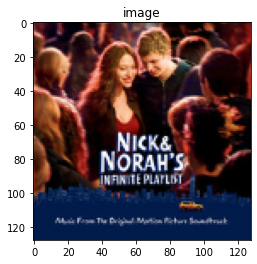

In [ ]:
immax = image.numpy().max()
immin = image.numpy().min()
im_range = 1
if immax > immin:
  im_range = immax-immin
image = (image/im_range)
plt.title('image')
plt.imshow(image)

In [ ]:
image_count = len(shortlisted_tracks_df.index.values)
image_row = 128
image_col = 128
image_ch = 3

msdi_aart_images = np.zeros((image_count, image_row, image_col, image_ch), dtype=np.float32)

for i, track_id in enumerate(shortlisted_tracks_df.index.values):
    parent_dir = 'data/' + track_id[2] + '/' + track_id[3] + '/' + track_id[4]
    filepath = parent_dir + '/' + track_id + '.jpg'
    raw_img = tf.io.read_file(filepath)
    img_decoded = tf.image.decode_jpeg(raw_img)
    img_tmp = tf.image.resize(img_decoded, [128, 128])
    immax = img_tmp.numpy().max()
    immin = img_tmp.numpy().min()
    im_range = 1
    if immax > immin:
      im_range = immax-immin
    img_norm = (img_tmp - immin)/im_range
    msdi_aart_images[i] = ((img_norm * 2) - 1)

In [ ]:
msdi_aart_images[2].max()

1.0

In [ ]:
msdi_aart_images[2].min()

-1.0

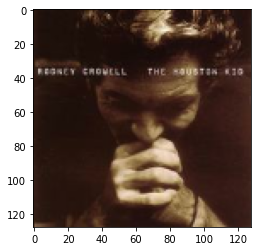

In [ ]:
img_pos = 2
plt.imshow(msdi_aart_images[img_pos]/2 + 0.5)

In [ ]:
module_suffix = '_aart'
genre_counts = 7

In [ ]:
shortlisted_tracks_df['Genre'] = shortlisted_tracks_df['Genre'].astype('category')
msdi_genres = keras.utils.to_categorical(shortlisted_tracks_df['Genre'].cat.codes, genre_counts)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(msdi_aart_images, msdi_genres, random_state=1)

In [ ]:
#Defining a function to save the objects as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_obj(x_train, 'x_train' + module_suffix)
save_obj(y_train, 'y_train' + module_suffix)

In [ ]:
save_obj(x_test, 'x_test' + module_suffix)
save_obj(y_test, 'y_test' + module_suffix)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1gtu8rKFhmDRJKlKkC91wUeUWlQP4_x8O/view?usp=sharing
file_id = r'1gtu8rKFhmDRJKlKkC91wUeUWlQP4_x8O'
# DESTINATION FILE ON YOUR DISK
destination = 'x_train_aart.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1psYyYADQ7R_9-RCOQNoCjqOAx1bfepXM/view?usp=sharing
file_id = r'1psYyYADQ7R_9-RCOQNoCjqOAx1bfepXM'
# DESTINATION FILE ON YOUR DISK
destination = 'x_test_aart.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1FWbFIGdsI6szMjkKTY6AvVpNo_xpgphM/view?usp=sharing
file_id = r'1FWbFIGdsI6szMjkKTY6AvVpNo_xpgphM'
# DESTINATION FILE ON YOUR DISK
destination = 'y_train_aart.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
# TAKE ID FROM SHAREABLE LINK
#https://drive.google.com/file/d/1EmE5y4d438fUMeszifAmCYn_60nx0P5B/view?usp=sharing
file_id = r'1EmE5y4d438fUMeszifAmCYn_60nx0P5B'
# DESTINATION FILE ON YOUR DISK
destination = 'y_test_aart.pkl'
download_file_from_google_drive(file_id, destination)

In [ ]:
with open('x_train' + module_suffix +'.pkl', 'rb') as handle:
    x_train = pickle.load(handle)

with open('y_train' + module_suffix +'.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [ ]:
with open('x_test' + module_suffix +'.pkl', 'rb') as handle:
    x_test = pickle.load(handle)

with open('y_test' + module_suffix +'.pkl', 'rb') as handle:
    y_test = pickle.load(handle)

In [ ]:
x_train.shape

(3675, 128, 128, 3)

In [ ]:
y_train.shape

(3675, 7)

In [ ]:
x_train[np.isnan(x_train)] = 0
x_test[np.isnan(x_test)] = 0

In [ ]:
#x_train.shape

In [ ]:
from keras.layers import Dense, Activation, Flatten, Conv1D, Dropout, MaxPooling1D

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), input_shape=x_train[0].shape, activation='relu', kernel_initializer='he_uniform'))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))

model.add(Dense(genre_counts, activation='softmax', kernel_initializer='he_uniform'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7ffb14c063d0>>

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(x_train, y_train, epochs=20, batch_size=64, callbacks=[callback], verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
58/58 [==============================] - 402s 7s/step - loss: 8.0648 - accuracy: 0.1630 - val_loss: nan - val_accuracy: 0.1992
Epoch 2/20
58/58 [==============================] - 400s 7s/step - loss: 1.8991 - accuracy: 0.2278 - val_loss: nan - val_accuracy: 0.3535
Epoch 3/20
58/58 [==============================] - 398s 7s/step - loss: 1.6116 - accuracy: 0.4044 - val_loss: nan - val_accuracy: 0.4980
Epoch 4/20
58/58 [==============================] - 397s 7s/step - loss: 1.1468 - accuracy: 0.5940 - val_loss: nan - val_accuracy: 0.5731
Epoch 5/20
58/58 [==============================] - 398s 7s/step - loss: 0.7957 - accuracy: 0.7361 - val_loss: nan - val_accuracy: 0.6000
Epoch 6/20
58/58 [==============================] - 397s 7s/step - loss: 0.5626 - accuracy: 0.8117 - val_loss: nan - val_accuracy: 0.6073
Epoch 7/20
58/58 [==============================] - 398s 7s/step - loss: 0.4356 - accuracy: 0.8607 - val_loss: nan - val_accuracy: 0.6188
Epoch 8/20
58/58 [================

KeyboardInterrupt: ignored